In [56]:
from pathlib import Path
import json
import pandas as pd

from corr_analysis_functions import (
    get_models_set,
    model_task_count,
    filter_common_models,
    kendall_w,
    normalize_scores,
    rank_with_margin,
)
from corr_plotting import plot_radar_chart, plot_ranks, ranks_chart, plot_corr_matrix

In [57]:
folder = Path("")
dataset_file = folder / "tasks_results.json"

with open(dataset_file, "r") as file:
    task_results = json.load(file)

# convert all model names to lower
task_results = {
    key: {key_in.lower(): value_in for key_in, value_in in value.items()}
    for key, value in task_results.items()
}
del task_results["plcc_proj_lev_path_dist_em"]

JSONDecodeError: Expecting property name enclosed in double quotes: line 64 column 5 (char 2001)

In [43]:
for task, scores in task_results.items():
    task_results[task] = normalize_scores(scores)

In [44]:
model_dict = get_models_set(task_results)
model_count = model_task_count(task_results)
model_list = sorted(list(model_count.keys()))
task_results_common = filter_common_models(task_results)

In [45]:
# if False:
#     with open("model_count.json", "w") as file:
#         json.dump(model_count, file, indent=4)
#     with open("model_list.txt", "w") as file:
#         file.write("\n".join(model_list))

In [46]:
task_results_df = pd.DataFrame(task_results_common)
# task_results_df.loc["best"] = 1.0
# task_results_df.loc["worst"] = 0.0
# task_results_ranked = task_results_df.rank(ascending=False, method='min')
task_results_ranked = rank_with_margin(task_results_df, margin=0.1)
# task_spearman_corr = task_results_df.corr(method='spearman')

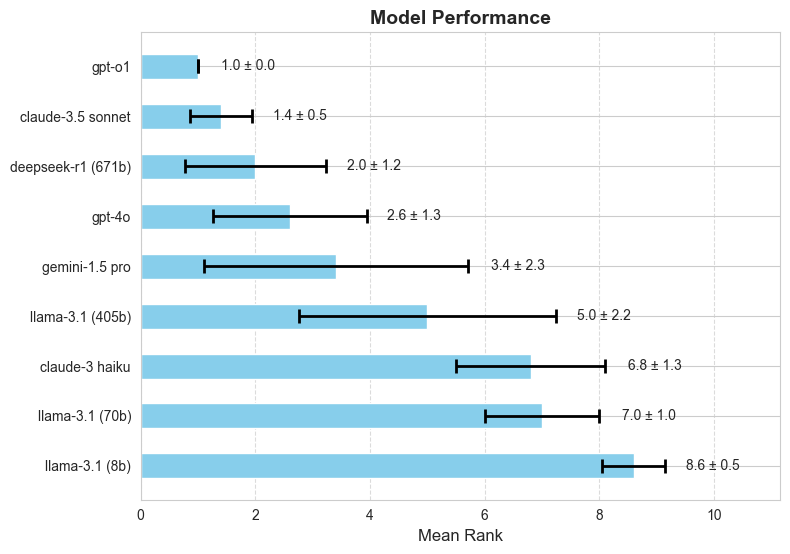

,Mean Rank,Std Dev
gpt-o1,1.0,0.000000
claude-3.5 sonnet,1.4,0.547723
deepseek-r1 (671b),2.0,1.224745
gpt-4o,2.6,1.341641
gemini-1.5 pro,3.4,2.302173
llama-3.1 (405b),5.0,2.236068
claude-3 haiku,6.8,1.303840
llama-3.1 (70b),7.0,1.000000
llama-3.1 (8b),8.6,0.547723


In [47]:
mean_ranks = task_results_ranked.mean(axis=1)
std_ranks = task_results_ranked.std(axis=1)
rank_stats = pd.DataFrame({"Mean Rank": mean_ranks, "Std Dev": std_ranks})
rank_stats.sort_values(by="Mean Rank", ascending=True, inplace=True)
ranks_chart(rank_stats)
rank_stats

In [48]:
task_results_df["Mean score"] = task_results_df.mean(axis=1)
results_agg = task_results_df.join(rank_stats)
results_agg

,Bug localization,CI-build-repair,CMG,Library based CG,Module summarization,Mean score,Mean Rank,Std Dev
claude-3 haiku,0.489209,0.083333,0.738353,0.496042,0.523997,0.466187,6.8,1.303840
claude-3.5 sonnet,0.784173,1.000000,0.929634,0.910290,0.622345,0.849288,1.4,0.547723
deepseek-r1 (671b),0.838129,0.958333,0.933274,0.643799,0.660897,0.806887,2.0,1.224745
gemini-1.5 pro,0.705036,0.416667,0.930443,0.817942,0.093627,0.592743,3.4,2.302173
gpt-4o,0.798561,0.416667,0.928017,0.733509,0.692368,0.713824,2.6,1.341641
gpt-o1,0.974820,1.000000,0.991508,0.825858,1.000000,0.958437,1.0,0.000000
llama-3.1 (8b),0.000000,0.000000,0.774749,0.000000,0.000000,0.154950,8.6,0.547723
llama-3.1 (70b),0.165468,0.208333,0.876658,0.274406,0.018096,0.308592,7.0,1.000000
llama-3.1 (405b),0.575540,0.166667,0.928826,0.622691,0.106216,0.479988,5.0,2.236068


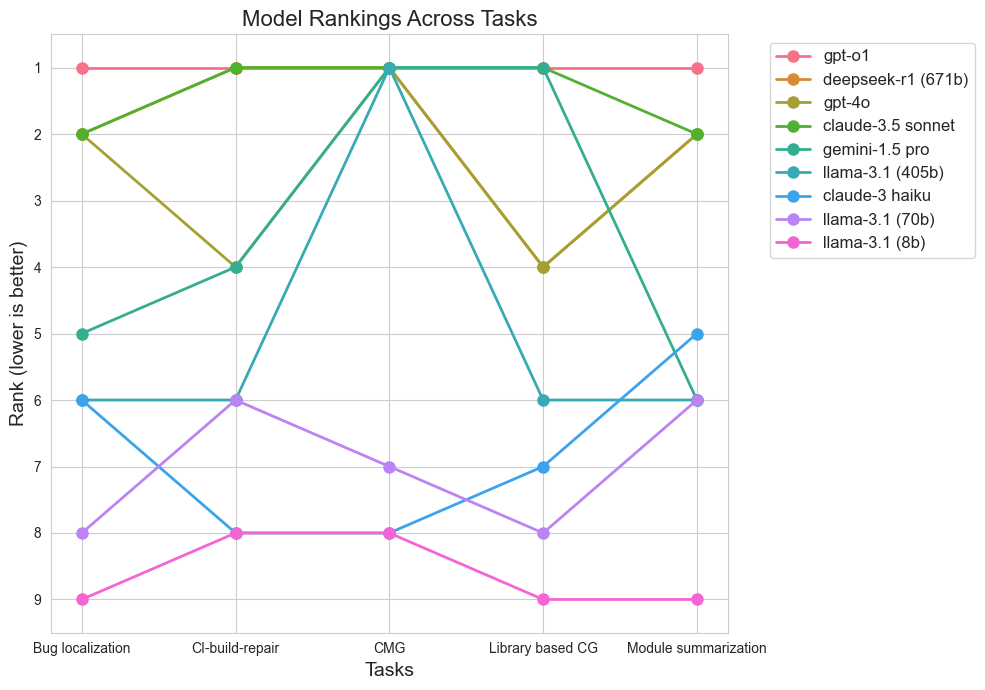

In [49]:
plot_ranks(task_results_ranked)

In [50]:
# plot_corr_matrix(task_results_df)

In [51]:
kendall_w(task_results_df)

{'W': 0.009353316241187275,
 'chi2': 0.4489591795769892,
 'p_value': 0.9999115292802653}

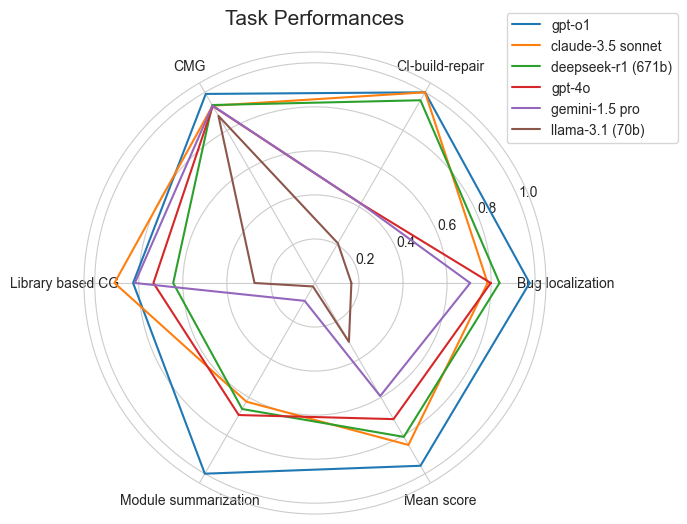

In [52]:
models_to_plot = ["gpt-o1", "claude-3.5 sonnet", "deepseek-r1 (671b)", "gpt-4o", "gemini-1.5 pro", "llama-3.1 (70b)"]
task_results_to_plot = task_results_df.filter(items=models_to_plot, axis=0)
plot_radar_chart(task_results_to_plot)

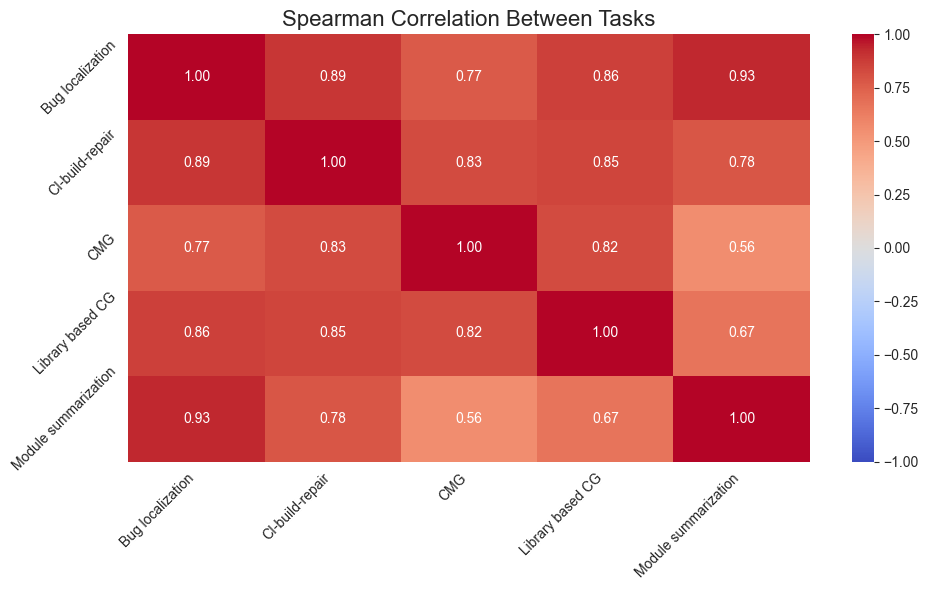

In [53]:
plot_corr_matrix(task_results_ranked)